# Compare characteristics of extended droughts and pluvials from SM-REC: 800-2023 CE

### Start Clean

In [1]:
# Reset the environment (start clean)
%reset -f

# Import Modules and define functions
import calendar
import datetime
import os
import numpy as np
import numpy.ma as ma
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import scipy.signal
import scipy.io as sio
import seaborn as sns
import pandas as pd
import scipy.stats as stats
#import statsmodels.api as sm
from IPython.display import display
import IPython
import requests
import pandas as pd
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf 
import matplotlib.colors as colors

# cartopy stuff
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry.polygon import LinearRing
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Borders for mapping: Cultural borders
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
# Coastline
newcoast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        edgecolor='k',
                                        facecolor='none')
#Lakes
newlake = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='k',
                                        facecolor='none')

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For asymetric colorbars
# https://matplotlib.org/stable/tutorials/colors/colormapnorms.html?highlight=twoslopenorm#twoslopenorm-different-mapping-on-either-side-of-a-center
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# For plotting a rectangle on the maps
def plot_rectangle(ax, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    ax.plot(xs,ys,color='k',linestyle='--',linewidth=3,transform=ccrs.PlateCarree())

# For plotting a point on a map
def plot_point(ax,lon,lat):
    xs = [lon]
    ys = [lat]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    #ax.scatter(xs,ys,color=np.array([0.5,0.5,0.5]),marker='*',linewidth=3,transform=ccrs.PlateCarree())
    ax.scatter(xs,ys,color='k',edgecolors='k',marker='+',linewidth=0.5,s=5,transform=ccrs.PlateCarree(),zorder=2,alpha=0.5)

ocean_color = np.float64([209,230,241])/255
nmap=plt.get_cmap(name=plt.cm.BrBG,lut=12) # only needed to set bins for pcolor/pcolormesh
      
# Month Vector
mons     = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Set plot styles
# Formatting for titles
fontdict_title = {'fontsize': 36}
fig_size = np.array([10,10])

# Formatting for figures
style_new = {'xtick.direction': 'in', \
             'ytick.direction': 'in', \
             'font.sans-serif': 'Arial'}


## Compare Tree-Ring Reconstructed vs Observations to Look for Dry or Wet Biases
### recon.txt
1) year
2) full best-estimate record, where pre-1901 is recon and 1901-2023 is observations
3) recon only
4) observations only

Rec, 1905-1923:  19.959509999999998
Obs, 1905-1923:  17.488720999999998
---------------------------------------
Rec, 1941-1945:  5.41079
Obs, 1941-1945:  7.703230000000001


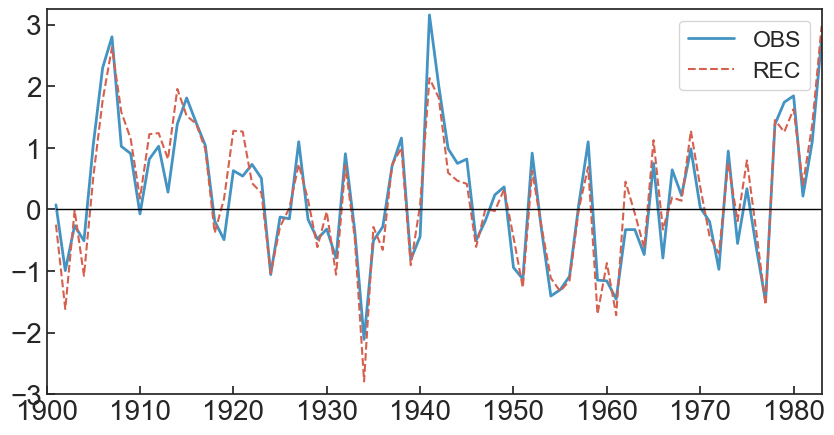

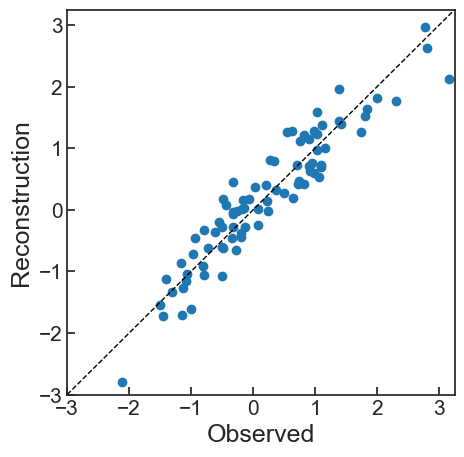

In [3]:
# Load into dataframe
pd_SMobsrec = pd.read_csv('../data/smrec/recon_obs_tree.txt',delimiter=',')

# Pull out year, recon only, obs only series
yr      = np.array(pd_SMobsrec['year'][:])
reconly = np.array(pd_SMobsrec['reconly'][:])
obsonly = np.array(pd_SMobsrec['obsonly'][:])

# Find Overlapping recon/obs years
i_over = np.where( (reconly>-1000) & (obsonly>=-1000))[0]

# Pull out these data
yr_over  = yr[i_over].copy()
rec_over = reconly[i_over].copy()
obs_over = obsonly[i_over].copy()

# Time series plot
plt.figure(figsize=(10,5),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.plot(yr_over,obs_over,color='#4393c3',linewidth=2,label='OBS')
plt.plot(yr_over,rec_over,color='#d6604d',linestyle='--',linewidth=1.5,label='REC')
plt.plot(yr_over,yr_over*0,'-', color='k', linewidth=1)
plt.legend(loc=0)
plt.xlim(1900,1983)
plt.ylim(-3,3.25)
plt.yticks([-3,-2,-1,0,1,2,3],fontsize=20)
plt.xticks(fontsize=20)
#plt.savefig('../figures/obs_vs_rec_timeseries.eps',format='eps')

# Scatter plot comparison
plt.figure(figsize=(5,5),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
plt.plot(np.array([-3,3.25]),np.array([-3,3.25]),'--', color='k', linewidth=1)
plt.scatter(obs_over,rec_over)
plt.xlim(-3,3.25)
plt.ylim(-3,3.25)
plt.yticks([-3,-2,-1,0,1,2,3],fontsize=15)
plt.xticks([-3,-2,-1,0,1,2,3],fontsize=15)
plt.xlabel('Observed')
plt.ylabel('Reconstruction')
#plt.savefig('../figures/obs_vs_rec_scatter.eps',format='eps')

# Compare Instrumental vs Reconstructed Pluvial events
# Indices
i_05_23 = np.where( (yr_over>=1905) & (yr_over<=1923) )[0]
i_41_45 = np.where( (yr_over>=1941) & (yr_over<=1945) )[0]
# Mean soil moisture
rec_05_23 = np.sum(rec_over[i_05_23])
obs_05_23 = np.sum(obs_over[i_05_23])
rec_41_45 = np.sum(rec_over[i_41_45])
obs_41_45 = np.sum(obs_over[i_41_45])

# Print to Screen
print('Rec, 1905-1923: ', rec_05_23)
print('Obs, 1905-1923: ', obs_05_23)
print('---------------------------------------')
print('Rec, 1941-1945: ', rec_41_45)
print('Obs, 1941-1945: ', obs_41_45)


In [4]:
scipy.stats.pearsonr(obs_over,rec_over)

PearsonRResult(statistic=0.9411159322707269, pvalue=6.653299439987561e-40)

## Load Park's reconstruction

In [5]:
# Load into dataframe
pd_SMseries = pd.read_csv('../data/smrec/recon_2023.txt',delimiter=',')

# Pull out bias-corrected reconustruction and observational time series
sm_obs_yr = np.array(pd_SMseries['year'][:])
sm_obs_all = np.array(pd_SMseries['recon'][:])

# For zero line
y_zeros = np.zeros(sm_obs_yr.shape)

# Create Rolling Means of soil moisture
sm_5yr  = np.array(pd.Series(sm_obs_all).rolling(5).mean())
sm_10yr = np.array(pd.Series(sm_obs_all).rolling(10).mean())


## Load pluvial/drought characteristics

In [7]:
# Load data
df_pluvial = pd.read_csv('../data/pluv_sm10yr_update_2024.csv')
df_drought = pd.read_csv('../data/drght_sm10yr_update_2024.csv')

# Pull out duration/odd years/cumsum
dur_pluv    = np.array(df_pluvial['Duration']); dur_drgt    = np.array(df_drought['Duration'])
cumsum_pluv = np.array(df_pluvial['CumSum']);   cumsum_drgt = np.array(df_drought['CumSum'])
outyrs_pluv = np.array(df_pluvial['DryYrs']);   outyrs_drgt = np.array(df_drought['WetYrs'])

# Specific values for 20th century events
i_loc = np.where(df_pluvial.FirstYr==1978)[0]; pluv_late20th  = df_pluvial.iloc[i_loc,:]
i_loc = np.where(df_pluvial.FirstYr==1905)[0]; pluv_early20th = df_pluvial.iloc[i_loc,:]
i_loc = np.where(df_drought.FirstYr==2000)[0]; drgt_early21st = df_drought.iloc[i_loc,:]


## Create array list of all extended pluvial/drought years

# extended pluvial years = 488
# extended drought years = 463
# other years = 273
# SUM = 1224
# TOTAL YEARS = 1224


(-4.2, 3.2)

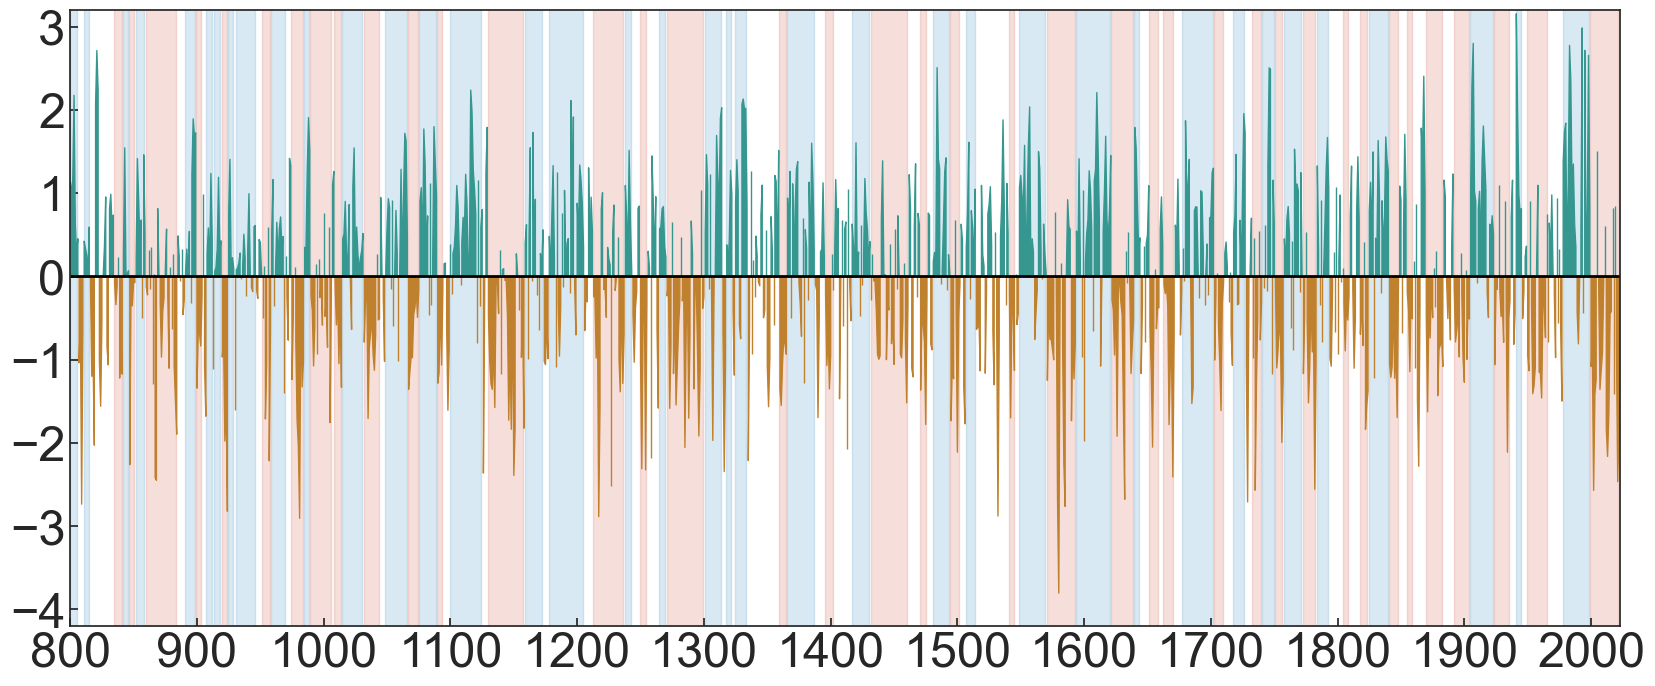

In [8]:
# Set minimum drought/pluvial length
min_len = 1

# Pull out list of first and last year of pluvial events-------------------------------------------------------
pluv_yrbeg  = np.array(df_pluvial.FirstYr[df_pluvial['Duration']>=min_len])
pluv_yrend  = np.array(df_pluvial.LastYr[df_pluvial['Duration']>=min_len])
pluv_length = np.array(df_pluvial.Duration[df_pluvial['Duration']>=min_len])
pluv_yrterm = pluv_yrend+1

# Loop through pluvial events
for n_pluv in np.arange(0,pluv_yrbeg.size):  
    # All years, current pluvial
    currpluv_yrs = np.arange(pluv_yrbeg[n_pluv],pluv_yrend[n_pluv]+1)

    # If first event, use this to initialize all years array
    if n_pluv==0:
        allpluv_yrs = currpluv_yrs.copy()
    # Otherwise, append
    else:
        allpluv_yrs = np.hstack((allpluv_yrs,currpluv_yrs))
    
print('# extended pluvial years =',np.size(allpluv_yrs))

# Pull out list of first and last year of drought events-------------------------------------------------------
drgt_yrbeg  = np.array(df_drought.FirstYr[df_drought['Duration']>=min_len])
drgt_yrend  = np.array(df_drought.LastYr[df_drought['Duration']>=min_len])
drgt_length = np.array(df_drought.Duration[df_drought['Duration']>=min_len])
drgt_yrterm = drgt_yrend+1

# Loop through pluvial events
for n_drgt in np.arange(0,drgt_yrbeg.size):  
    # All years, current pluvial
    currdrgt_yrs = np.arange(drgt_yrbeg[n_drgt],drgt_yrend[n_drgt]+1)

    # If first event, use this to initialize all years array
    if n_drgt==0:
        alldrgt_yrs = currdrgt_yrs.copy()
    # Otherwise, append
    else:
        alldrgt_yrs = np.hstack((alldrgt_yrs,currdrgt_yrs))
    
print('# extended drought years =',np.size(alldrgt_yrs))

# Years that don't fall within the extended droughts or pluvials
allother_yrs = np.setxor1d(sm_obs_yr,np.hstack((alldrgt_yrs,allpluv_yrs)))

print('# other years =',np.size(allother_yrs))

print('# SUM =',np.size(allother_yrs)+np.size(alldrgt_yrs)+np.size(allpluv_yrs))
print('# TOTAL YEARS =',sm_obs_yr.size)

# Figure: unsmoothed
plt.figure(figsize=(20,8),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
plt.plot(sm_obs_yr,y_zeros,'-', color='k', linewidth=2)
# Shading
i_neg=sm_obs_all.copy(); i_neg[np.where(i_neg>=0)]=0; i_neg[np.where(i_neg<0)]=1
i_pos=sm_obs_all.copy(); i_pos[np.where(i_neg==0)]=1; i_pos[np.where(i_neg==1)]=0
plt.fill_between(sm_obs_yr, y_zeros, sm_obs_all, where=i_neg, color='#bf812d', alpha=1)
plt.fill_between(sm_obs_yr, y_zeros, sm_obs_all, where=i_pos, color='#35978f', alpha=1)
plt.yticks([-4,-3,-2,-1,0,1,2,3,4],fontsize=35)
# Highlight Extended Droughts
for n_event in enumerate(drgt_length):
#    ymin=-5; ymax=-3
    ymin=-5; ymax=3.5
    if n_event[1]>=1:
        plt.fill_between(np.arange(drgt_yrbeg[n_event[0]]-0.5,drgt_yrend[n_event[0]]+0.5), ymin, ymax,color='#d6604d',alpha=0.2,zorder=0)
# Highlight Extended Pluvials
for n_event in enumerate(pluv_length):
#    ymin=2; ymax=3.5
    ymin=-5; ymax=3.5
    if n_event[1]>=1:
        plt.fill_between(np.arange(pluv_yrbeg[n_event[0]]-0.5,pluv_yrend[n_event[0]]+0.5), ymin, ymax,color='#4393c3',alpha=0.2,zorder=0)
plt.xticks([800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000],fontsize=35)
plt.xlim(800,2023)
plt.ylim(-4.2,3.2)
#plt.savefig('../figures/sm200_recon_1yr_update_pluvs_drghts.pdf',format='pdf')

# # Figure: 10-year smoothed version
# plt.figure(figsize=(20,8),facecolor="white")
# sns.set_style("ticks",style_new)
# sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
# plt.plot(sm_obs_yr,y_zeros,'-', color='k', linewidth=2)
# # Shading
# i_neg=sm_10yr.copy(); i_neg[np.where(i_neg>=0)]=0; i_neg[np.where(i_neg<0)]=1
# i_pos=sm_10yr.copy(); i_pos[np.where(i_neg==0)]=1; i_pos[np.where(i_neg==1)]=0
# plt.fill_between(sm_obs_yr, y_zeros, sm_10yr, where=i_neg, color='#bf812d', alpha=1)
# plt.fill_between(sm_obs_yr, y_zeros, sm_10yr, where=i_pos, color='#35978f', alpha=1)
# plt.yticks([-1.0,-0.5,0,0.5,1.0,1.5],fontsize=35)
# # Highlight Extended Droughts
# for n_event in enumerate(drgt_length):
#     ymin=-5; ymax=-0.75
#     plt.fill_between(np.arange(drgt_yrbeg[n_event[0]]-0.5,drgt_yrend[n_event[0]]+0.5), ymin, ymax,color='#d6604d',alpha=0.2,zorder=0)
# # Highlight Extended Pluvials
# for n_event in enumerate(pluv_length):
#     ymin=1; ymax=3.5
#     plt.fill_between(np.arange(pluv_yrbeg[n_event[0]]-0.5,pluv_yrend[n_event[0]]+0.5), ymin, ymax,color='#4393c3',alpha=0.2,zorder=0)
# plt.xticks([800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000],fontsize=35)
# plt.xlim(800,2023)
# plt.ylim(-1.3,1.5)
# #plt.savefig('../figures/sm200_recon_10yr_update_2023.pdf',format='pdf')

## Calculate Number of Pluvial/Drought Years for different 100-year moving windows

Text(0.5, 1.0, 'number of drought years per century')

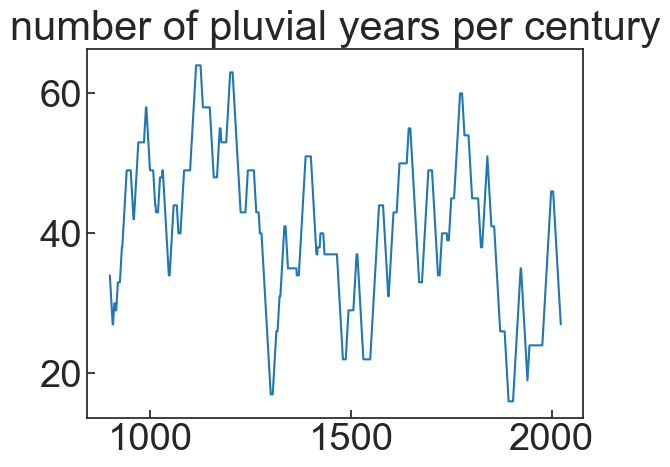

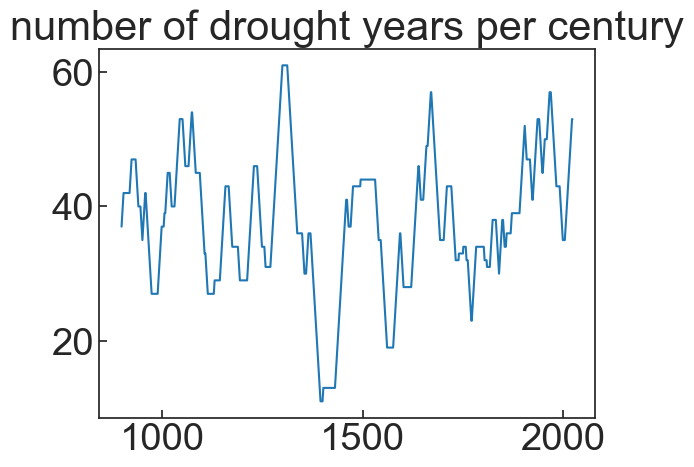

In [9]:
# End Window
end_yrs = np.arange(899,2023+1)

# Storage arrays 
numpluv_yrs_wind = np.zeros(end_yrs.size)*np.nan
numdrgt_yrs_wind = np.zeros(end_yrs.size)*np.nan

# Loop for windows
for n_end in enumerate(end_yrs):
    beg_yr = n_end[1]-99
    
    # All years for window
    allyrs_wind = np.arange(beg_yr,n_end[1]+1)

    # Calculate number of pluvial/drought years in this window
    numpluv_yrs_wind[n_end[0]] = np.intersect1d(allyrs_wind,allpluv_yrs).size
    numdrgt_yrs_wind[n_end[0]] = np.intersect1d(allyrs_wind,alldrgt_yrs).size
    
plt.figure()
plt.plot(end_yrs,numpluv_yrs_wind)
plt.title('number of pluvial years per century')

plt.figure()
plt.plot(end_yrs,numdrgt_yrs_wind)
plt.title('number of drought years per century')
    

## Print 10 Most Severe Pluvials

In [10]:
#df_pluvial.sort_values('Duration',ascending=False)[0:10]
df_pluvial.sort_values('CumSum',ascending=False)[0:10]

,FirstYr,LastYr,Duration,DryYrs,MeanAnom,CumSum
37,1978.0,1999.0,22.0,4.0,1.083398,23.834758
35,1905.0,1923.0,19.0,3.0,0.920459,17.488721
14,1100.0,1125.0,26.0,4.0,0.628379,16.337848
27,1594.0,1621.0,28.0,5.0,0.578894,16.209043
26,1549.0,1570.0,22.0,4.0,0.612051,13.465124
16,1178.0,1205.0,28.0,8.0,0.458425,12.835889
34,1825.0,1840.0,16.0,2.0,0.755921,12.094740
29,1678.0,1702.0,25.0,7.0,0.446758,11.168955
21,1325.0,1334.0,10.0,2.0,1.109762,11.097620
13,1076.0,1089.0,14.0,2.0,0.783204,10.964860


## Print 10 Most Severe Droughts

In [11]:
#df_drought.sort_values('Duration',ascending=False)[0:10]
df_drought.sort_values('CumSum',ascending=True)[0:10]

,FirstYr,LastYr,Duration,WetYrs,MeanAnom,CumSum
12,1130.0,1158.0,29.0,6.0,-0.707502,-20.517569
38,2000.0,2022.0,23.0,4.0,-0.868366,-19.972408
22,1571.0,1593.0,23.0,6.0,-0.815888,-18.765429
15,1271.0,1300.0,30.0,5.0,-0.539348,-16.180442
2,860.0,884.0,25.0,9.0,-0.497656,-12.441403
6,975.0,984.0,10.0,1.0,-1.149478,-11.494780
23,1622.0,1639.0,18.0,2.0,-0.593682,-10.686273
13,1213.0,1237.0,25.0,8.0,-0.396860,-9.921491
29,1773.0,1783.0,11.0,1.0,-0.879939,-9.679330
37,1950.0,1966.0,17.0,4.0,-0.548026,-9.316436


## Play With Some Color Palettes

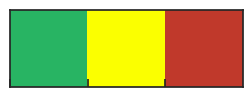

In [12]:
# Create New Color Palette
#box_cmap = sns.palplot([sns.color_palette('BrBG')[0],sns.color_palette('BrBG')[-1],np.array([240,240,240])/255])
#box_cmap = sns.palplot(['#35978f','#bf812d','#f5f5f5'])
#mycolors = matplotlib.colors.ListedColormap(sns.color_palette(box_cmap))
#sns.color_palette(box_cmap)

gyr = ['#28B463','#FBFF00', '#C0392B']
sns.palplot(sns.color_palette(gyr))
my_colors = matplotlib.colors.ListedColormap(sns.color_palette(gyr))


# Soil Moisture Values for Drought and Pluvial Years

/var/folders/tn/n6r82fln4w96xwgsmyktfwjh0000gn/T/ipykernel_82642/35894599.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
/var/folders/tn/n6r82fln4w96xwgsmyktfwjh0000gn/T/ipykernel_82642/35894599.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Category", y="value", data=df_comp_var, whis=100, palette="BrBG")


(-0.5, 2.5)

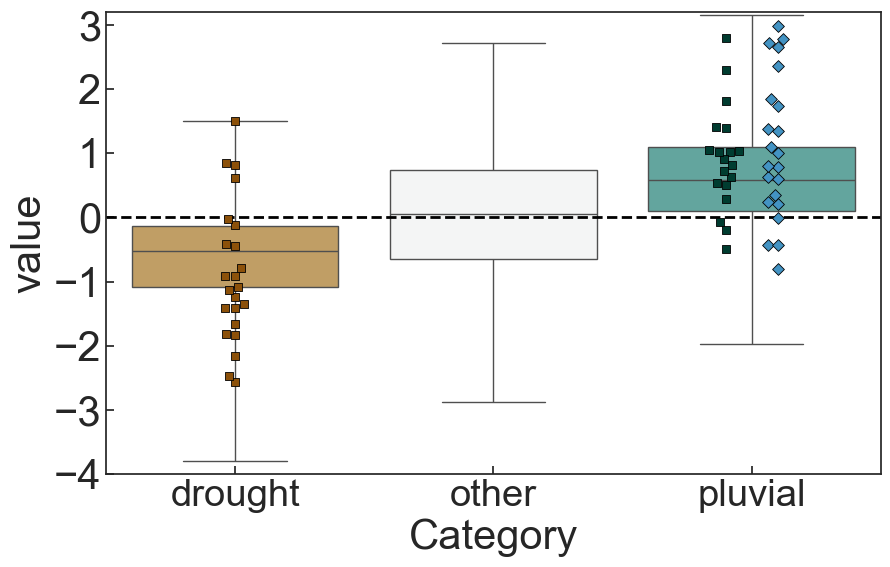

In [27]:
# Find these years
i_pluv  = np.nonzero(np.in1d(sm_obs_yr,allpluv_yrs))[0]
i_drgt  = np.nonzero(np.in1d(sm_obs_yr,alldrgt_yrs))[0]
i_other = np.nonzero(np.in1d(sm_obs_yr,allother_yrs))[0]

# Copy them
sm_pluv  = sm_obs_all[i_pluv].copy()
sm_drgt  = sm_obs_all[i_drgt].copy()
sm_other = sm_obs_all[i_other].copy()

# Concatenate soil moisture categories into single dataframe for plotting---------------------------------------------------------

# Initialize dataframe for plotting (all years)
#df_comp_var = pd.DataFrame(columns=('SM','Category'),index=None)
df_comp_var = pd.DataFrame(columns=('Category','value'),index=None)

# extended drought loop
for n_ev in np.arange(0,sm_drgt.size):
    # Conjoin
    df_join = pd.DataFrame([['drought',sm_drgt[n_ev]]],columns=['Category','value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
# other years loop
for n_ev in np.arange(0,sm_other.size):
    # Conjoin
    df_join = pd.DataFrame([['other',sm_other[n_ev]]],columns=['Category','value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

    # extended pluvial loop
for n_ev in np.arange(0,sm_pluv.size):
    # Conjoin
    df_join = pd.DataFrame([['pluvial',sm_pluv[n_ev]]],columns=['Category','value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

# Concatenate soil moisture for singular events---------------------------------------------------------------------------------

# Late Pluvial
df_latepluv = pd.DataFrame(columns=['Category','value'])
df_latepluv['value']    = sm_obs_all[np.where( (sm_obs_yr>=1978) & (sm_obs_yr<=1999) )]
df_latepluv['Category'] = 'pluvial' 
df_latepluv=pd.concat([pd.DataFrame([['other',np.nan]],columns=['Category','value']), df_latepluv], ignore_index=True)
df_latepluv=pd.concat([pd.DataFrame([['drought',np.nan]],columns=['Category','value']), df_latepluv], ignore_index=True)

# Early Pluvial
df_earlypluv = pd.DataFrame(columns=['Category','value'])
df_earlypluv['value']    = sm_obs_all[np.where( (sm_obs_yr>=1905) & (sm_obs_yr<=1923) )]
df_earlypluv['Category'] = 'pluvial' 
df_earlypluv=pd.concat([pd.DataFrame([['other',np.nan]],columns=['Category','value']), df_earlypluv], ignore_index=True)
df_earlypluv=pd.concat([pd.DataFrame([['drought',np.nan]],columns=['Category','value']), df_earlypluv], ignore_index=True)

# Megadrought
df_mega21st = pd.DataFrame(columns=['Category','value'])
df_mega21st['value']    = sm_obs_all[np.where( (sm_obs_yr>=2000) & (sm_obs_yr<=2022) )]
df_mega21st['Category'] = 'drought' 
df_mega21st=pd.concat([df_mega21st,pd.DataFrame([['other',np.nan]],columns=['Category','value'])], ignore_index=True)
df_mega21st=pd.concat([df_mega21st,pd.DataFrame([['pluvial',np.nan]],columns=['Category','value'])], ignore_index=True)

# Create Alt Plot--------------------------------------------------------------------------------------------------------------------
    
plt.figure(figsize=(10,6),facecolor="white")
sns.set_style("ticks",style_new)
ax = sns.boxplot(x="Category", y="value", data=df_comp_var, whis=100, palette="BrBG")
ax=sns.swarmplot(y=df_mega21st['value'],x=np.ones(df_mega21st['value'].size)-1,color='#8c510a',marker='s',s=6,edgecolor='k',linewidth=0.6,zorder=100,orient='v',native_scale=True)
ax=sns.swarmplot(y=df_earlypluv['value'],x=np.ones(df_earlypluv['value'].size)+0.9,color='#003c30',marker='s',s=6,edgecolor='k',linewidth=0.6,zorder=100,orient='v',native_scale=True)
ax=sns.swarmplot(y=df_latepluv['value'],x=np.ones(df_latepluv['value'].size)+1.1,color='#4393c3',marker='D',s=6,edgecolor='k',linewidth=0.6,zorder=100,orient='v',native_scale=True)
plt.yticks(np.arange(-4,4),fontsize=30), plt.ylim(-4,3.2)
plt.plot(np.arange(-0.5,3.5),np.arange(-0.5,3.5)*0,'--', color='k', linewidth=2)
plt.xlim(-0.5,2.5)
#plt.savefig('../figures/boxplot_soilmoisture_2023_altplot.pdf',format='pdf')


## Concatenate statistics into single dataframe for creating seaborn plots

/var/folders/tn/n6r82fln4w96xwgsmyktfwjh0000gn/T/ipykernel_82642/407552940.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)


(0.0, 31.0)

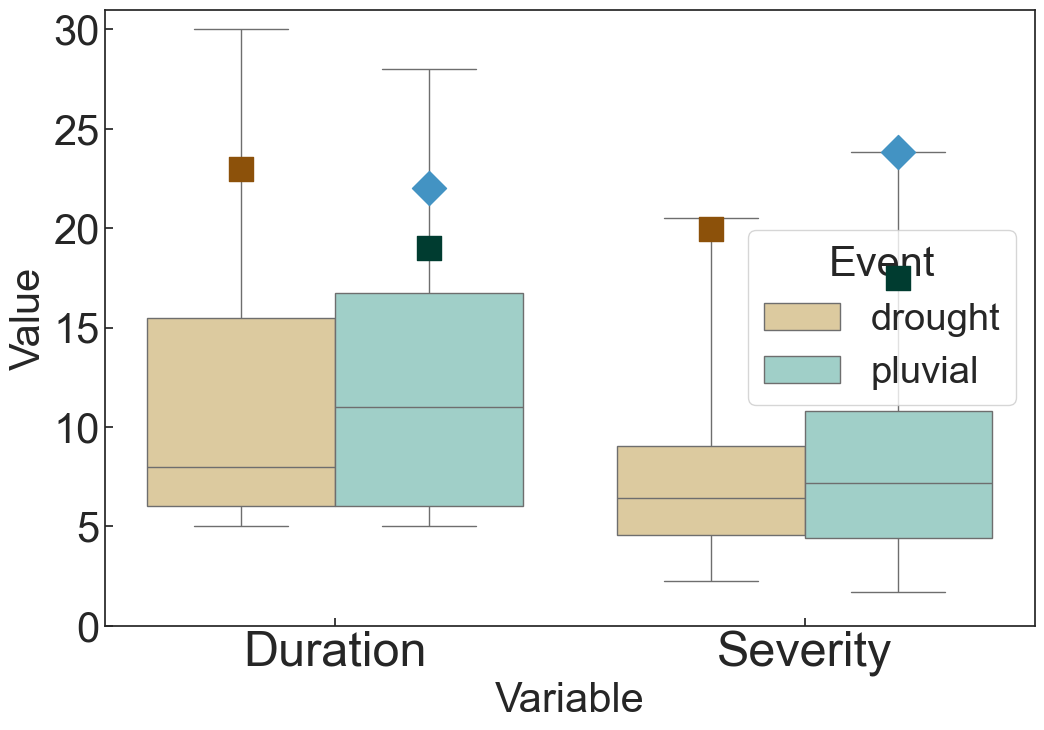

In [28]:
# Initialize dataframe
df_comp_var = pd.DataFrame(columns=('Event','Variable','Value'),index=None)

# Concatenate drought/pluvial statistics into single dataframe

# drought loop
for n_ev in np.arange(0,dur_drgt.size):
    
    # Duration
    df_join = pd.DataFrame([['drought','Duration',dur_drgt[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

    # Cumsum
    df_join = pd.DataFrame([['drought','Severity',np.abs(cumsum_drgt[n_ev])]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

#    # Outyears
#    df_join = pd.DataFrame([['drought','outyrs',outyrs_drgt[n_ev]]],columns=['Event','Variable','Value'])
#    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
# pluvial loop
for n_ev in np.arange(0,dur_pluv.size):
    
    # Duration
    df_join = pd.DataFrame([['pluvial','Duration',dur_pluv[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)

    # Cumsum
    df_join = pd.DataFrame([['pluvial','Severity',cumsum_pluv[n_ev]]],columns=['Event','Variable','Value'])
    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
#    # Outyears
#    df_join = pd.DataFrame([['pluvial','outyrs',outyrs_pluv[n_ev]]],columns=['Event','Variable','Value'])
#    df_comp_var = pd.concat([df_comp_var, df_join], ignore_index=True)
    
df_comp_var

plt.figure(figsize=(12,8),facecolor="white")
sns.set_style("ticks",style_new)
ax = sns.boxplot(x="Variable", y="Value", hue="Event", data=df_comp_var, whis=100, palette="BrBG")
plt.yticks(np.arange(0,40,5),fontsize=30)
plt.xticks(np.arange(0,2,1),fontsize=35)
# Early 20th Century Pluvial
plt.scatter(0.2,pluv_early20th.Duration,s=300,zorder=10,color='#003c30',marker='s')
plt.scatter(1.2,pluv_early20th.CumSum,s=300,zorder=10,color='#003c30',marker='s')
# Late 20th Century Pluvial
plt.scatter(0.2,pluv_late20th.Duration,s=300,zorder=10,color='#4393c3',marker='D')
plt.scatter(1.2,pluv_late20th.CumSum,s=300,zorder=10,color='#4393c3',marker='D')
# Early 21st Century Drought
plt.scatter(-0.2,drgt_early21st.Duration,s=300,zorder=10,color='#8c510a',marker='s')
plt.scatter(0.8,drgt_early21st.CumSum*-1,s=300,zorder=10,color='#8c510a',marker='s')
plt.ylim(0,31)
#plt.savefig('../figures/boxplot_20th_21stcent_events_2023.pdf',format='pdf')
